In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_and_binarize(image_path):
    """Load an image and binarize it."""
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    _, bin_img = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    return bin_img

def create_mask(template):
    """Create a mask for templates 4 and 6."""
    mask = np.zeros_like(template, dtype=np.uint8)
    contours, _ = cv.findContours(template, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(mask, contours, -1, 255, thickness=cv.FILLED)
    mask = cv.bitwise_not(mask)
    return 255 - mask

In [10]:
def find_best_scale_and_detect_digits(main_image, templates):
    """Find the best scale using pyramid scaling and detect digits."""
    scales = [0.5, 0.75, 1.25, 1.5, 2.0]  # Possible scales to test
    best_scale = 1.0
    threshold = 0.95
    best_matches = []

    for digit, (tmpl, mask) in templates.items():
        res = cv.matchTemplate(main_image, tmpl, cv.TM_CCORR_NORMED, mask=mask)
        loc = np.where(res >= threshold)  
        for pt in zip(*loc[::-1]):
            top_left = pt
            bottom_right = (top_left[0] + tmpl.shape[1], top_left[1] + tmpl.shape[0])
            max_val = res[top_left[1], top_left[0]] 
            best_matches.append((max_val, digit, top_left, bottom_right))
    
    for scale in scales:
        scaled_img = cv.resize(main_image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        scale_matches = []

        for digit, (tmpl, mask) in templates.items():
            res = cv.matchTemplate(scaled_img, tmpl, cv.TM_CCORR_NORMED, mask=mask)
            loc = np.where(res >= threshold)  # Все точки, где корреляция >= threshold

            for pt in zip(*loc[::-1]):  # Перебор всех подходящих точек
                top_left = pt
                bottom_right = (top_left[0] + tmpl.shape[1], top_left[1] + tmpl.shape[0])
                max_val = res[top_left[1], top_left[0]]  # Значение корреляции
                scale_matches.append((max_val, digit, top_left, bottom_right))

        if sum(match[0] for match in scale_matches) > sum(match[0] for match in best_matches):
            best_scale = scale
            best_matches = scale_matches

    return best_scale, best_matches

In [70]:
def plot_results(main_image, detected_positions, scale):
    """Plot the results with rectangles and digit labels."""
    scaled_img = cv.resize(main_image, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
    
    for _, digit, top_left, bottom_right in detected_positions:
        cv.rectangle(scaled_img, top_left, bottom_right, (255, 0, 0), 2)
        cv.putText(scaled_img, str(digit), (top_left[0], top_left[1] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    plt.imshow(scaled_img, cmap='gray')
    plt.title("Detected Digits")
    plt.axis('off')
    plt.show()

Специально уменьшил в 2 раза основную картинку. Шаблоны нарезались с большей картинки

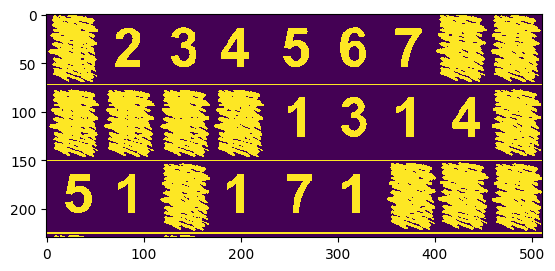

In [5]:
main_image_path = "digits_main_image.png" 
main_image = load_and_binarize(main_image_path)
plt.imshow( main_image, interpolation = 'none' );

np.uint8(0)

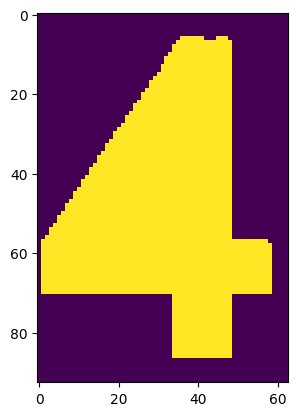

In [50]:
template_path = f"template_4.png"  # Replace with your template paths
tmpl = load_and_binarize(template_path)
tmpl_mask = create_mask(tmpl)
plt.imshow( tmpl_mask, interpolation = 'none' );
tmpl_mask[0, 0]

In [64]:
templates = {}
for digit in range(1, 8):
    template_path = f"template_{digit}.png"
    tmpl = load_and_binarize(template_path)
    # tmpl_mask = create_mask(tmpl) if digit in [4, 6] else None
    tmpl_mask = None
    templates[digit] = (tmpl, tmpl_mask)

In [73]:
best_scale, detected_positions = find_best_scale_and_detect_digits(main_image, templates)
best_scale

2.0

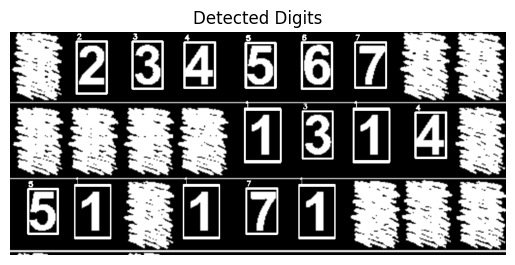

In [72]:
plot_results(main_image, detected_positions, best_scale)